In [ ]:
# ==========================================
# AIRPORT CLUSTERING 
# CHUNK 1: Data Loading & Advanced Aggregation
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
DATA_FILE = 'US_flights_2023.csv'

print("--- 1. Loading Flight Data ---")
cols_to_load = ['FlightDate', 'Dep_Airport', 'Dep_Delay', 'Arr_Delay', 'Airline']
df = pd.read_csv(DATA_FILE, usecols=cols_to_load, low_memory=False)

df = df.dropna(subset=['Dep_Delay', 'Arr_Delay'])

print(f"Data Loaded: {len(df):,} flights.")

print("\n--- 2. Engineering Airport ---")
airport_df = df.groupby('Dep_Airport').agg(
    total_flights=('Dep_Delay', 'count'),
    avg_dep_delay=('Dep_Delay', 'mean'),
    avg_arr_delay=('Arr_Delay', 'mean'),
    # STD DEV measures "Reliability". High Std Dev = Unpredictable/Chaotic.
    delay_volatility=('Dep_Delay', 'std'),
    # Count unique airlines to identify "Hubs" vs "Single Carrier" airports
    unique_airlines=('Airline', 'nunique')
).reset_index()

airport_df['delay_volatility'] = airport_df['delay_volatility'].fillna(0)

print("\n--- 3. Filtering Outliers ---")
# We keep only airports with significant traffic (> 1000 flights/year).
original_count = len(airport_df)
airport_df = airport_df[airport_df['total_flights'] > 1000].copy()

print(f"Removed {original_count - len(airport_df)} small airports.")
print(f"Final Dataset: {len(airport_df)} Airports ready for clustering.")

print("\nTop 5 Busiest Airports:")
print(airport_df.sort_values('total_flights', ascending=False).head(5))

--- 1. Loading Flight Data ---
Data Loaded: 6,743,404 flights.

--- 2. Engineering Airport 'Report Cards' ---

--- 3. Filtering Outliers ---
Removed 118 small airports.
Final Dataset: 232 Airports ready for clustering.

Top 5 Busiest Airports:
    Dep_Airport  total_flights  avg_dep_delay  avg_arr_delay  \
21          ATL         332935      11.485443       5.760494   
91          DEN         284200      15.797055      10.309571   
92          DFW         280021      15.560737      11.294246   
238         ORD         255071      12.400042       7.315367   
70          CLT         192870      13.962742       9.978250   

     delay_volatility  unique_airlines  
21          43.722965               13  
91          48.514380               10  
92          60.299658               12  
238         52.793806               12  
70          57.204917               12  


--- 1. Scaling the Data ---
Data Scaled. Ready for clustering algorithms.

--- 2. finding Optimal 'k' (The Elbow Method) ---


c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

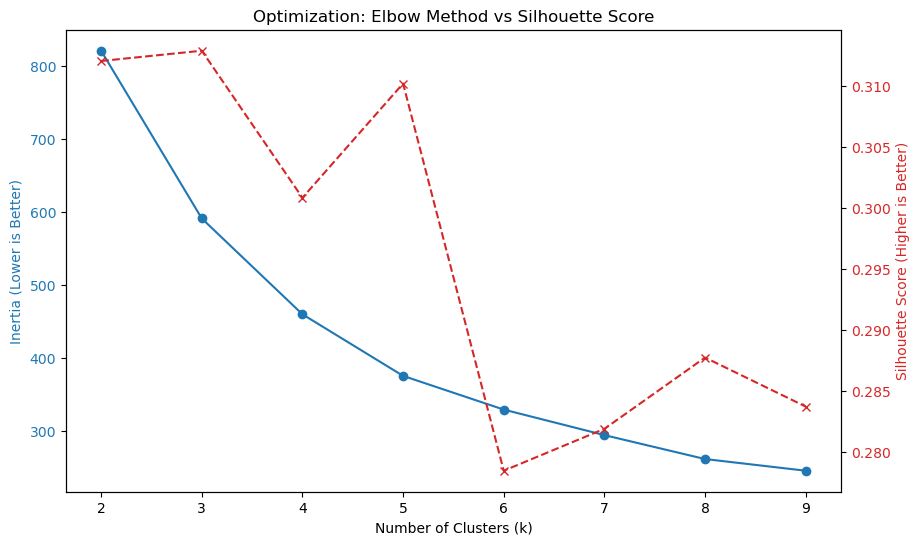

Mathematical Recommendation: The highest Silhouette Score is at k=3.
Look at the red dashed line. The peak (highest point) is usually the best choice.


In [ ]:
# ==========================================
# CHUNK 2: Scaling & Finding 'k' for KMeans
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = ['total_flights', 'avg_dep_delay', 'avg_arr_delay', 'delay_volatility', 'unique_airlines']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(airport_df[features])

print("Data Scaled. Ready for clustering algorithms.")

print("\n--- 2. finding Optimal 'k' ---")
wcss = []
sil_scores = [] 
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Lower is Better)', color=color)
ax1.plot(K_range, wcss, color=color, marker='o', label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Silhouette (Score) - Look for the Peak
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score (Higher is Better)', color=color)
ax2.plot(K_range, sil_scores, color=color, marker='x', linestyle='--', label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Optimization: Elbow Method vs Silhouette Score')
plt.show()

# Recommendation
best_k = K_range[np.argmax(sil_scores)]
print(f"Mathematical Recommendation: The highest Silhouette Score is at k={best_k}.")


--- Applying K-Means with 5 Clusters ---
Clusters assigned.


c:\Users\gmatt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


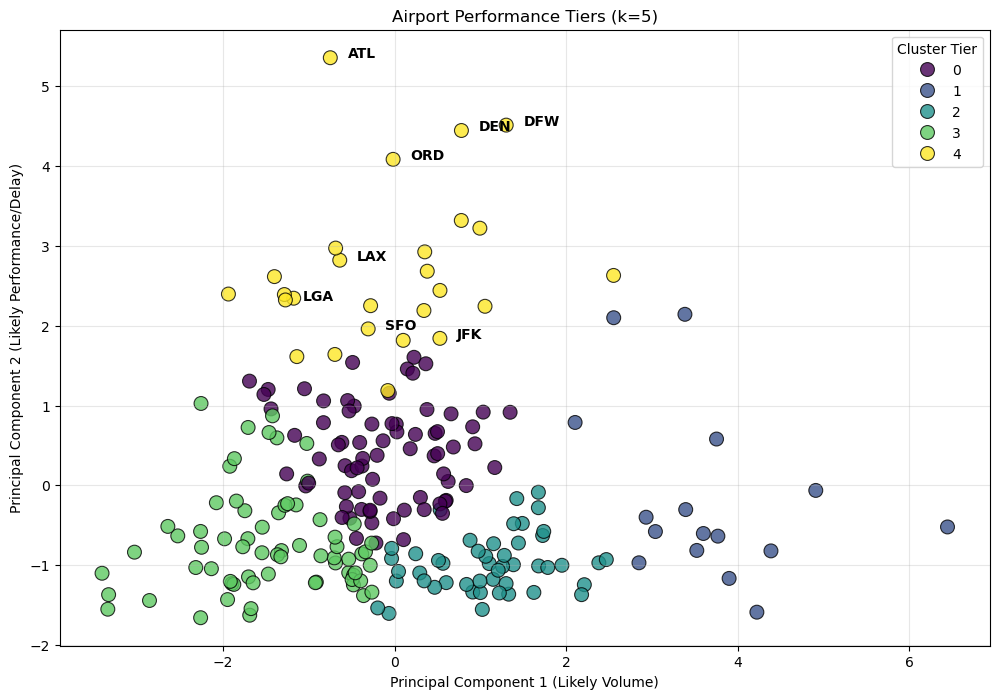


--- Tier Interpretation (The 'Why') ---
                  Count  Avg_Flights  Avg_Delay  Reliability_StdDev  \
Performance_Tier                                                      
4                    26    156298.62      12.71               51.79   
0                    74     20535.41      10.51               62.55   
1                    16     17328.44      20.08               81.13   
3                    68      9605.69       6.90               50.58   
2                    48      3421.96      12.37               74.87   

                  Unique_Airlines  
Performance_Tier                   
4                           11.35  
0                           10.16  
1                            4.69  
3                            4.32  
2                            3.58  


In [ ]:
# ==========================================
# CHUNK 3: Running K-Means (k=5) & PCA Visualization
# ==========================================
from sklearn.decomposition import PCA

optimal_k = 5 
print(f"--- Applying K-Means with {optimal_k} Clusters ---")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

airport_df['Performance_Tier'] = clusters
print("Clusters assigned.")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1 (Size/Volume)', 'PC2 (Delay/Chaos)'])
pca_df['Tier'] = clusters
pca_df['Airport'] = airport_df['Dep_Airport'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1 (Size/Volume)', 
    y='PC2 (Delay/Chaos)', 
    hue='Tier', 
    data=pca_df, 
    palette='viridis', 
    s=100, 
    alpha=0.8,
    edgecolor='black'
)

famous_airports = ['ATL', 'ORD', 'LAX', 'DFW', 'DEN', 'JFK', 'SFO', 'LGA']
for i in range(len(pca_df)):
    code = pca_df.loc[i, 'Airport']
    if code in famous_airports:
        plt.text(
            pca_df.loc[i, 'PC1 (Size/Volume)']+0.2, 
            pca_df.loc[i, 'PC2 (Delay/Chaos)'], 
            code, 
            fontsize=10, 
            weight='bold',
            color='black'
        )

plt.title(f'Airport Performance Tiers (k={optimal_k})')
plt.xlabel('Principal Component 1 (Likely Volume)')
plt.ylabel('Principal Component 2 (Likely Performance/Delay)')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster Tier')
plt.show()

print("\n--- Tier Interpretation ---")
summary = airport_df.groupby('Performance_Tier').agg(
    Count=('Dep_Airport', 'count'),
    Avg_Flights=('total_flights', 'mean'),
    Avg_Delay=('avg_dep_delay', 'mean'),
    Reliability_StdDev=('delay_volatility', 'mean'),
    Unique_Airlines=('unique_airlines', 'mean')
).sort_values(by='Avg_Flights', ascending=False)

print(summary.round(2))

--- Running DBSCAN (Density-Based Clustering) ---


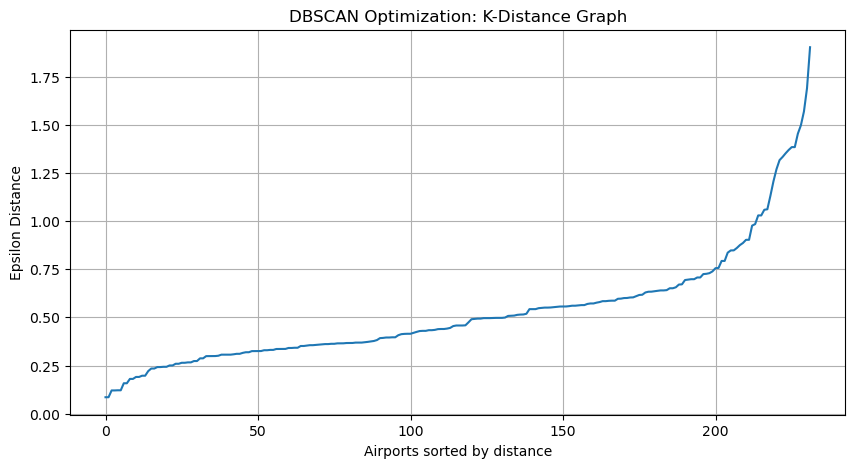

Look at the 'Elbow' in the graph above. That is your optimal Epsilon.


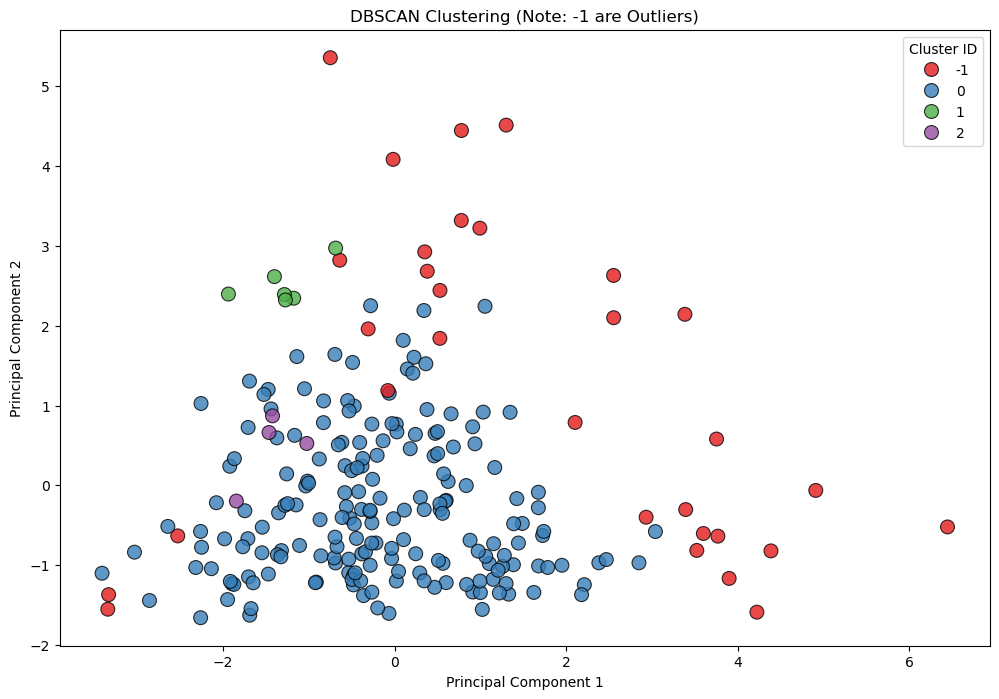


--- Comparison: K-Means vs DBSCAN ---
K-Means groups (Forced partitions):
Performance_Tier
0    74
1    16
2    48
3    68
4    26
Name: count, dtype: int64

DBSCAN groups (Density based):
DBSCAN_Cluster
 0    191
-1     31
 1      6
 2      4
Name: count, dtype: int64
Note: Cluster '-1' represents Outliers (Airports that don't fit anywhere).


In [ ]:
# ==========================================
# TASK 2 - CHUNK 3.5: DBSCAN (Syllabus Requirement)
# ==========================================
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

print("--- Running DBSCAN (Density-Based Clustering) ---")

# 1. OPTIMIZE EPSILON (The 'Elbow' for DBSCAN)
# DBSCAN is hard to tune. We use NearestNeighbors to find the right 'eps' distance.
# We look at the distance to the 4th nearest neighbor (standard heuristic).
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to plot the "K-distance Graph"
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('DBSCAN Optimization: K-Distance Graph')
plt.xlabel('Airports sorted by distance')
plt.ylabel('Epsilon Distance')
plt.grid(True)
plt.show()

print("Look at the 'Elbow' in the graph above. That is your optimal Epsilon.")

dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

airport_df['DBSCAN_Cluster'] = dbscan_labels


pca_df['DBSCAN'] = dbscan_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1 (Size/Volume)', 
    y='PC2 (Delay/Chaos)', 
    hue='DBSCAN', 
    data=pca_df, 
    palette='Set1',
    s=100, 
    alpha=0.8,
    edgecolor='black'
)
plt.title('DBSCAN Clustering (Note: -1 are Outliers)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID')
plt.show()

print("\n--- Comparison: K-Means vs DBSCAN ---")
print("K-Means groups (Forced partitions):")
print(airport_df['Performance_Tier'].value_counts().sort_index())

print("\nDBSCAN groups (Density based):")
print(airport_df['DBSCAN_Cluster'].value_counts())
print("Note: Cluster '-1' represents Outliers (Airports that don't fit anywhere).")

--- Training Classifier to Predict Airport Tiers ---

--- Classification Report ---
                          precision    recall  f1-score   support

      Tier 0 (Secondary)       1.00      0.82      0.90        17
      Tier 1 (High Risk)       1.00      1.00      1.00         2
Tier 2 (Underperforming)       1.00      0.89      0.94         9
      Tier 3 (Efficient)       0.81      1.00      0.90        13
       Tier 4 (Mega-Hub)       0.86      1.00      0.92         6

                accuracy                           0.91        47
               macro avg       0.93      0.94      0.93        47
            weighted avg       0.93      0.91      0.92        47



C:\Users\gmatt\AppData\Local\Temp\ipykernel_24676\3501252563.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='viridis')


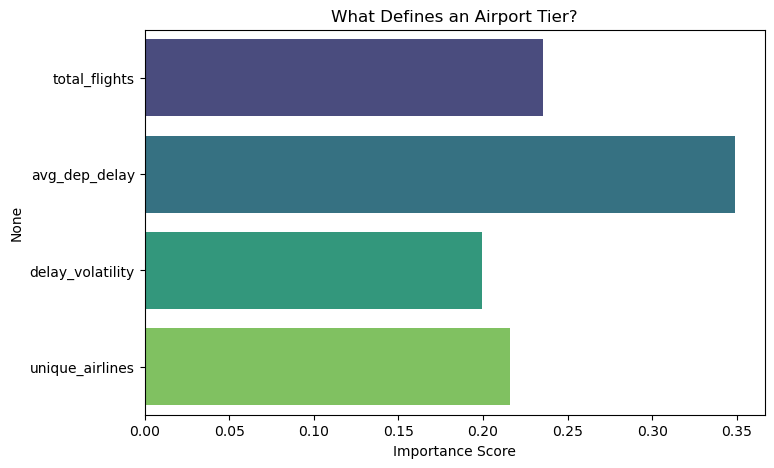

In [ ]:
# ==========================================
# TCHUNK 4: Classification
# ==========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("--- Training Classifier to Predict Airport Tiers ---")

# 1. PREPARE DATA
# Target: The Tier we just created (0-4)
# Features: The stats (Flights, Delay, Volatility, Airlines)
X_cls = airport_df[['total_flights', 'avg_dep_delay', 'delay_volatility', 'unique_airlines']]
y_cls = airport_df['Performance_Tier']

# Split (80/20)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# 2. TRAIN MODEL
# We use a Random Forest Classifier (as requested in PDF)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_c, y_train_c)

# 3. EVALUATE
y_pred_c = clf.predict(X_test_c)

print("\n--- Classification Report ---")
# We map the numbers to our new professional names for the report
tier_names = ['Tier 0 (Secondary)', 'Tier 1 (High Risk)', 'Tier 2 (Underperforming)', 'Tier 3 (Efficient)', 'Tier 4 (Mega-Hub)']
# Note: Check unique classes in test set to ensure names match indices present
unique_labels = sorted(y_test_c.unique())
target_names_present = [tier_names[i] for i in unique_labels]

print(classification_report(y_test_c, y_pred_c, target_names=target_names_present))

# 4. FEATURE IMPORTANCE (The "Why")
importances = clf.feature_importances_
feat_names = X_cls.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feat_names, palette='viridis')
plt.title('What Defines an Airport Tier?')
plt.xlabel('Importance Score')
plt.show()

In [ ]:
# ==========================================
# FINAL CHUNK: Enrich, Save & Merge Data
# ==========================================

print("--- 1. Loading Geolocation Data ---")
df_geo = pd.read_csv('airports_geolocation.csv')

print("--- 2. Enriching Airport Report Card ---")
# Merge our 'airport_df' (Calculated Stats + Tiers) with 'df_geo' (Names + Locations)
# airport_df: Dep_Airport <-> df_geo: IATA_CODE
airport_enriched = airport_df.merge(
    df_geo[['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'LATITUDE', 'LONGITUDE']],
    left_on='Dep_Airport',
    right_on='IATA_CODE',
    how='left'
)
airport_enriched = airport_enriched.drop(columns=['IATA_CODE'])

cols_order = [
    'Dep_Airport', 'AIRPORT', 'CITY', 'STATE', 'Performance_Tier', 
    'total_flights', 'avg_dep_delay', 'delay_volatility', 'unique_airlines',
    'LATITUDE', 'LONGITUDE'
]
cols_final = [c for c in cols_order if c in airport_enriched.columns]
airport_enriched = airport_enriched[cols_final]

print("Added Airport Names and Locations.")
print(airport_enriched.head(3))

airport_enriched.to_csv('airport_performance_tiers_enriched.csv', index=False)
print("Success! Saved 'airport_performance_tiers_enriched.csv'.")

print("\n--- Merging Tiers back to Main Flight Data ---")

if 'Performance_Tier' not in df.columns:
    df_final_tagged = df.merge(
        airport_enriched[['Dep_Airport', 'Performance_Tier']],
        on='Dep_Airport',
        how='left'
    )
    print("Merged 'Performance_Tier' into flight data.")
else:
    print("Updating Performance Tiers...")
    df = df.drop(columns=['Performance_Tier'], errors='ignore')
    df_final_tagged = df.merge(
        airport_enriched[['Dep_Airport', 'Performance_Tier']],
        on='Dep_Airport',
        how='left'
    )

print("\nPreview of Master Dataset for Task 3:")
print(df_final_tagged[['FlightDate', 'Airline', 'Dep_Airport', 'Performance_Tier', 'Dep_Delay']].head())

--- 1. Loading Geolocation Data ---


--- 2. Enriching Airport Report Card ---
Enrichment Complete. Added Airport Names and Locations.
  Dep_Airport                              AIRPORT         CITY STATE  \
0         ABE  Lehigh Valley International Airport    Allentown    PA   
1         ABI             Abilene Regional Airport      Abilene    TX   
2         ABQ    Albuquerque International Sunport  Albuquerque    NM   

   Performance_Tier  total_flights  avg_dep_delay  delay_volatility  \
0                 0           4368       9.269002         69.766792   
1                 3           1341       6.342282         40.508078   
2                 0          23273       9.981867         53.246396   

   unique_airlines  LATITUDE  LONGITUDE  
0                6  40.65236  -75.44040  
1                1  32.41132  -99.68190  
2               10  35.04022 -106.60919  

--- 3. Saving Final Task 2 Deliverable ---
Success! Saved 'airport_performance_tiers_enriched.csv'.

--- 4. Merging Tiers back to Main Flight Data ---
Merge

In [ ]:
# ==========================================
# BONUS: Interactive Map of US Airports
# ==========================================
import folium

print("--- Generating Interactive Map ---")

# 1. SETUP MAP CENTER (USA)
us_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4, tiles='CartoDB positron')

# 2. DEFINE COLOR PALETTE (Matching our Professional Tiers)
# Tier 4 (Mega-Hubs) -> Gold/Orange (Busy!)
# Tier 3 (Efficient) -> Green (Good!)
# Tier 1 (High Risk) -> Red (Warning!)
# Tier 0 (Secondary) -> Purple (Standard)
# Tier 2 (Underperforming) -> Blue (Cold/Slow)
tier_colors = {
    4: '#FFD700', # Gold
    3: '#2ecc71', # Green
    2: '#3498db',  # Blue
    1: '#e74c3c', # Red
    0: '#9b59b6', # Purple
    
}

tier_names = {
    4: 'Mega-Hub',
    3: 'Efficient Regional',
    2: 'Underperforming',
    1: 'High Risk / Chaotic',
    0: 'Secondary Hub',
    
}

# 3. ADD MARKERS
for idx, row in airport_enriched.iterrows():
    if pd.isna(row.get('LATITUDE')) or pd.isna(row.get('LONGITUDE')):
        continue
    tier = int(row.get('Performance_Tier', -1))
    
    popup_text = (
        f"<b>{row.get('Dep_Airport','')}</b><br>"
        f"{row.get('CITY','')}, {row.get('STATE','')}<br>"
        f"<b>Tier:</b> {tier} ({tier_names.get(tier, 'Unknown')})<br>"
        f"Avg Delay: {row.get('avg_dep_delay',0):.1f} min<br>"
        f"Flights: {int(row.get('total_flights',0)):,}"
    )

    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=6, 
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=f"{row.get('Dep_Airport','')} ({tier_names.get(tier)})", 
        color='black',     
        weight=1,
        fill=True,
        fill_color=tier_colors.get(tier, 'gray'),
        fill_opacity=0.8
    ).add_to(us_map)

legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 180px; height: 160px; 
     border:2px solid grey; z-index:9999; font-size:12px;
     background-color:white; opacity: 0.9; padding: 10px;">
     <b>Performance Tiers</b><br>
     <i style="background:#FFD700;width:10px;height:10px;display:inline-block;border-radius:50%"></i> Mega-Hub (Tier 4)<br>
     <i style="background:#2ecc71;width:10px;height:10px;display:inline-block;border-radius:50%"></i> Efficient (Tier 3)<br>
     <i style="background:#9b59b6;width:10px;height:10px;display:inline-block;border-radius:50%"></i> Secondary (Tier 0)<br>
     <i style="background:#3498db;width:10px;height:10px;display:inline-block;border-radius:50%"></i> Underperforming (Tier 2)<br>
     <i style="background:#e74c3c;width:10px;height:10px;display:inline-block;border-radius:50%"></i> High Risk (Tier 1)<br>
     </div>
     '''
us_map.get_root().html.add_child(folium.Element(legend_html))

# 5. DISPLAY
us_map

--- Generating Interactive Map ---
